In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

## Summery
1. Reading the files
2. Considerations
3. Modeling
# 

#### 1. Reading the files

In [2]:
SEED = 42

In [3]:
df = pd.read_csv('../data/data_fe.csv')
labels = pd.read_csv('../data/machine_learning_challenge_labeled_data.csv')

data = df.merge(labels, on='customer_id')
data.shape

(245455, 70)

#### 2. Considerations
* `Metric`: As we saw, the data is an imbalance, so picking the metric should be less sensitive to this part(EX. AUC is not the best metric because of that). In the good practical setup, we could use a **cost function** for confusion matrix(EX. what is the cost of losing someone by not detecting them(FP), or what is the cost of sending a voucher to someone is not going to be churn(FN)), But here we don't have that information, we need a metric another metric to look at. Another point is we need to have only one metric to compare things. It's nice to be able to compare models in different ways, but we need to pick one metric. Between **F1** and **average precision**, I chose **average precision** because at the same time we can use precision-recall plots as well.
* `Cross-validation`: I split the data into train-test(0.8-0.2) with keeping the ratio of the rare class in both sides. I don't have enough computation power to do k-fold validation, But it's something good to try.
* `Categorical Features`: Encoding categorical features can be tricky and it depends on the model. For example Tree based models are not good in handleing the OneHot encoding but Linear models are like it more, On the other hand binnery encoding is a good option for trees. One other way is to replace the feature with it counts. We may lose some infromation becasue of encoding, but it's we have to test and see which works better.
* `reproducibility`: I'm using SEED in all of the random part of models, to make them reproducibile.

### 3.Modeling

In [4]:
# target = data.is_returning_customer

In [5]:
cats = ['last_restaurant','last_city', 'last_order_payment_id', 'last_order_platform_id', 'last_order_transmission_id']

In [6]:
data[cats] = data[cats].astype('str')

In [7]:
data.isna().any()[data.isna().any() == True]

voucher_amount_std    True
delivery_fee_std      True
amount_paid_std       True
dtype: bool

In [8]:
data.fillna(-1,inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['customer_id', 'is_returning_customer'], axis=1),
    data.is_returning_customer,
    train_size = 0.8, shuffle= SEED, stratify=labels.is_returning_customer)


#### 3.01- UDF

In [30]:
def lc_plot(model, data, sizes=np.linspace(0.3, 1.0, 4), cv=StratifiedKFold(n_splits=4),  n_jobs=1): 
    X_train, y_train, _, _ = data
    visualizer = LearningCurve(
        model, cv=cv, scoring='average_precision', train_sizes=sizes, n_jobs= n_jobs)
    visualizer.fit(X_train, y_train)
    visualizer.show()  
    
def pr_plot(model, data):
    X_train, y_train, X_test, y_test = data
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
    

#### 3.1- Logistic Regression

In [25]:
# I could use the drop flag, but since I will use l1 penalty, it rally dosnt matter
ss = StandardScaler()
lr_X_train = ss.fit_transform(X_train.drop(cats, axis=1))
lr_X_test = ss.transform(X_test.drop(cats, axis=1))

lr_data = (lr_X_train, y_train, lr_X_test, y_test)


/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


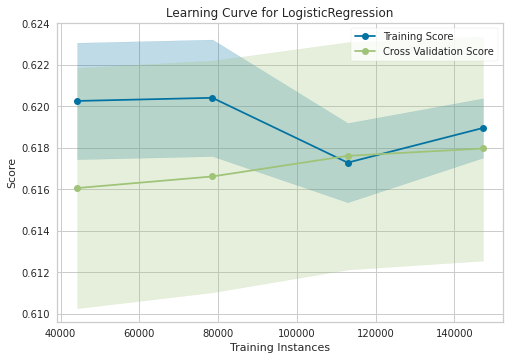

CPU times: user 40.5 s, sys: 10.2 s, total: 50.7 s
Wall time: 26 s


In [27]:
%%time
model = LogisticRegression(class_weight='balanced', max_iter=300)


lc_plot(model, lr_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


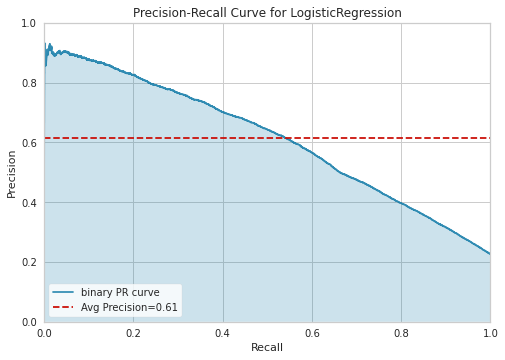

In [31]:
pr_plot(model, lr_data)

From these 2 plots, we can see by increasing the data, the validation score is getting better, therefore So more data could help. The Variance of prediction in 4fold is not that high, so to improve we could add more features or use a more complex model.